First we import all necessary libraries

In [319]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go
import chart_studio.plotly as py
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from dash import Dash, Input, Output, callback, dash_table
from plotly.subplots import make_subplots

# Data cleaning
As a first step the data is read in as a csv file.

In [320]:
data = pd.read_csv("Example_data_masterthesis.csv", sep = ";")

In [321]:
data.head()

,ID,Tested_system,Software_test,Test_result,Execution_date,Test runtime
0,1,System A,Log-in,1,03/02/2022,00:01:34
1,2,System A,Vertrag_a,1,03/02/2022,00:05:41
2,3,System A,Vertrag_b,1,03/02/2022,00:09:48
3,4,System A,Vertrag_c,1,03/02/2022,00:03:55
4,5,System A,Vertrag_d,1,03/02/2022,00:02:02


As we want to be able to add various different data, we change the column names, so that we can assure they stay the same. The old name of the columns will vary from data to data and will need to be adapted. 

In [322]:
data = data.rename(columns={"Tested_system":"system", "Software_test":"testname", "Test_result":"result", "Execution_date":"date", "Test runtime":"runtime"})

After the data is read in, we want to check, if all data types are set correct. As this is not the case, we set the correct types

In [323]:
data.dtypes

ID           int64
system      object
testname    object
result       int64
date        object
runtime     object
dtype: object

In [324]:
data = data.astype({"result": "bool", "date":"datetime64"})
#data = data.astype({"date":"datetime64"})
data["runtime"] = pd.to_datetime(data["runtime"], format= "%H:%M:%S").dt.time
data["date"] = pd.to_datetime(data["date"], format= "%D:%M:%Y").dt.date
data.head()

,ID,system,testname,result,date,runtime
0,1,System A,Log-in,True,2022-03-02,00:01:34
1,2,System A,Vertrag_a,True,2022-03-02,00:05:41
2,3,System A,Vertrag_b,True,2022-03-02,00:09:48
3,4,System A,Vertrag_c,True,2022-03-02,00:03:55
4,5,System A,Vertrag_d,True,2022-03-02,00:02:02


Now we check if there are any null values

In [325]:
data.isna().any()

ID          False
system      False
testname    False
result      False
date        False
runtime     False
dtype: bool

Here we set a column as an id.

In [326]:
data['id'] = data['ID']
data.set_index('id', inplace=True, drop=False)
print(data.columns)

Index(['ID', 'system', 'testname', 'result', 'date', 'runtime', 'id'], dtype='object')


In [327]:
sub_data = data [['system', 'result']]
sub_data = sub_data['result'].value_counts().to_frame()
#sub_data.value_counts().to_frame()
sub_data
#
#(sub_data.value_counts()).plot(kind="pie")

,result
True,15
False,5


array([<AxesSubplot:ylabel='result'>], dtype=object)

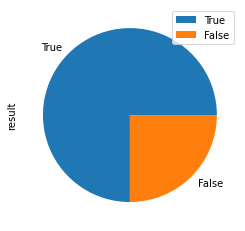

In [328]:
sub_data.plot(kind="pie", subplots=True)

In [329]:
dataset=data.groupby('result').size().reset_index(name='count')
dataset.replace(to_replace= "1", value = "Passed")
dataset
#fig = px.bar(dataset, x='result', y='count') 
#fig.show()

,result,count
0,False,5
1,True,15


In [330]:
fig = px.pie(
        data,
        names=data["result"].value_counts().index,
        values=data["result"].value_counts(),
        labels={1: "Success", 0: "Unsuccess"},
        hole=0.4,
    )
fig

In [331]:
fig = px.pie(dataset, values='count', names='result')
fig.show()

In [332]:
#data[data['system'] == "System B"]
option = []
for i in (data["system"].unique()):
    option.append(i)
print(option)

['System A', 'System B']


# Dashboard creation
Next we start building the dashboard.

In [333]:
app = Dash(__name__)

In [334]:
#app = dash.Dash(__name__, prevent_initial_callbacks=True)

option = []
        
for i in (data["system"].unique()):
    option.append(i)

app.layout = html.Div([
    html.Div([
        dash_table.DataTable(
        id='datatable-interactivity',
            columns=[
                {"name": i, "id": i, "deletable": False, "selectable": True, "hideable": True}
                # only a few columns in our data table are hideable
                if i == "ID" or i == "system" or i == "runtime" or i == "id"
                else {"name": i, "id": i, "deletable": False, "selectable": True}
                for i in data.columns
            ],

        data=data.to_dict('records'),
        filter_action="native",
        sort_action="native",
        sort_mode="single",
        column_selectable = "multi", 
        fixed_rows={'headers': True},
        row_selectable="multi",     # allow users to select 'multi' or 'single' rows
        row_deletable=True,         # choose if user can delete a row (True) or not (False)
        selected_columns=[],        # ids of columns that user selects
        selected_rows=[],           # indices of rows that user selects
        page_action="native",       # all data is passed to the table up-front or not ('none')
        style_table = {'height': '300px', 'overflowY': 'auto'},
        style_cell={                # ensure adequate header width when text is shorter than cell's text
            'minWidth': 95, 'maxWidth': 95, 'width': 95
        },
        style_cell_conditional=[    # align text columns to left. By default they are aligned to right
            {
                'if': {'column_id': c},
                'textAlign': 'left'
            } for c in ['testname', 'system']
        ],
        style_data={                # overflow cells' content into multiple lines
            'whiteSpace': 'normal',
            'height': 'auto'
        }
    ),

    ]),

    html.Br(),
    html.Br(),
    #data[data['system'] == option[0]]
    html.Div([
        html.Div([
            dcc.Dropdown(id='dropdown_1',
                options=[
                         {'label': option[0], 'value': 'system'},
                         {'label': option[1], 'value': 'testname'},
                         #{'label': option[2], 'value': 'testname'},
                         #{'label': option[3], 'value': 'testname'},
                ],
                #value='system',
                multi=True,
                clearable=True
            ),
        ],className='six columns'),
       
        html.Div(
             id='pie-container'
        ),

        ], className= 'row'),

   # html.Br(),
   # html.Br(),
    
    html.Div(id='choromap-container')
      
      ])

In [335]:
@app.callback( 
    Output(component_id='pie-container', component_property='children'),
    [Input(component_id='datatable-interactivity', component_property="derived_virtual_data"),
     Input(component_id='datatable-interactivity', component_property='derived_virtual_selected_rows'),
     Input(component_id='datatable-interactivity', component_property='derived_virtual_selected_row_ids'),
     Input(component_id='datatable-interactivity', component_property='selected_rows'),
     Input(component_id='datatable-interactivity', component_property='derived_virtual_indices'),
     Input(component_id='datatable-interactivity', component_property='derived_virtual_row_ids'),
     Input(component_id='datatable-interactivity', component_property='active_cell'),
     Input(component_id='datatable-interactivity', component_property='selected_cells')]
)
def update_pie(all_rows_data, slctd_row_indices, slct_rows_names, slctd_rows,
               order_of_rows_indices, order_of_rows_names, actv_cell, slctd_cell):

    dff = pd.DataFrame(all_rows_data)

    dff_sub=dff.groupby('result').size().reset_index(name='count')
    dff_sub["result"].replace(["true", "false"],["Passed", "Failed"])

    if "result" in dff:
        return [
            dcc.Graph(id='pie-chart',
                      figure=px.pie(
                          data_frame=dff_sub,
                          values= "count",
                          names= "result",
                      )
                    )
        ]

In [336]:
#@app.callback(
#    Output('datatable-interactivity', 'style_data_conditional'),
#    [Input('datatable-interactivity', 'selected_columns')]
#)
#def update_styles(selected_columns):
#    return [{
#        'if': {'column_id': i},
#        'background_color': '#D2F3FF'
#    } for i in selected_columns]


In [337]:
if __name__ == '__main__':
    app.run_server(debug=False)
    

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is run

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [28/Mar/2022 23:18:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:28] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_2_0m1648480726.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_favicon.ico?v=2.2.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\gaert\anaconda3\lib\site-packages\dash\dash.py", line 1344, in dispatch
    raise KeyError

127.0.0.1 - - [28/Mar/2022 23:18:29] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:29] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:33] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET /_favicon.ico?v=2.2.0 HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:45] "GET /_da

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\_compat.py", line 39, in reraise
    raise value
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1950, in full_dispatch_request
    rv = self.dispatch_request()
  File "C:\Users\gaert\anaconda3\lib\site-packages\flask\app.py", line 1936, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "C:\Users\gaert\anaconda3\lib\site-packages\dash\dash.py", line 1344, in dispatch
    raise KeyError

127.0.0.1 - - [28/Mar/2022 23:18:45] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [28/Mar/2022 23:18:46] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [28/Mar/2022 23:18:46] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Mar/2022 23:18:46] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
